In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.optimizers as optimizers

import sys
sys.path.append("..")

from models.regression_model import DemoRegressionDGP
from likelihoods import Gaussian
from utils_training import MCEM, MCEM_windows, MCEM_sampler_demo, MCEM_Q_maximizer_demo

from matplotlib import pyplot as plt

2022-08-24 12:00:17.046565: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-08-24 12:00:18.248305: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-08-24 12:00:18.304833: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:25:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 715.34GiB/s
2022-08-24 12:00:18.304874: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-08-24 12:00:18.308451: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-24 12:00:18.308484: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.

In [2]:
def get_sin_data(num_training, num_testing, std_noise=0.01):
    X_1 = np.random.uniform(-2., -1., num_training//2)
    X_2 = np.random.uniform(1., 2., num_training - num_training//2)
    X_train = np.concatenate([X_1, X_2])
    Y_train = np.sin(np.pi * X_train) + np.random.randn(num_training) * std_noise
    X_train = np.reshape(X_train, [num_training, 1])
    Y_train = np.reshape(Y_train, [num_training, 1])
    #nomalize the data
    y_mean = np.average(Y_train)
    y_std = np.std(Y_train)
    Y_train = (Y_train - y_mean)/y_std
    
    X_test = np.linspace(-5., 5., num_testing)[:, None]
    Y_test = (np.sin(np.pi * X_test) - y_mean)/y_std
    
    return np.float32(X_train), np.float32(Y_train), np.float32(X_test), np.float32(Y_test)

def load_demo_data(num_training, num_testing, batch_size, std_noise=0.01):
    X_train, Y_train, X_test, Y_test= get_sin_data(num_training, num_testing, std_noise=std_noise)
    ds_X_train = tf.data.Dataset.from_tensor_slices(X_train)
    ds_Y_train = tf.data.Dataset.from_tensor_slices(Y_train)
    ds_train = tf.data.Dataset.zip((ds_X_train, ds_Y_train))
    ds_X_test = tf.data.Dataset.from_tensor_slices(X_test)
    ds_Y_test = tf.data.Dataset.from_tensor_slices(Y_test)
    ds_test = tf.data.Dataset.zip((ds_X_test, ds_Y_test))

    ds_train = ds_train.shuffle(num_training)
    # ds_test = ds_test.shuffle(num_testing)
    ds_train = ds_train.batch(batch_size) # not using full data as one batch
    ds_test = ds_test.batch(num_testing)
    return ds_train, ds_test, X_test

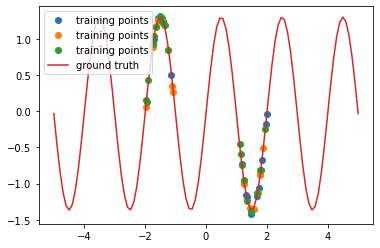

In [3]:
num_training = 60
num_testing = 100
batch_size = 20
std_noise = 0.02

ds_train, ds_test, X_test = load_demo_data(num_training, num_testing, batch_size, std_noise=std_noise)
for x, y in ds_train:
    plt.plot(x[:,0], y[:,0], 'o',linewidth=0.5, label='training points')
for x, y in ds_test:
    plt.plot(x[:,0], y[:,0], label='ground truth')
plt.legend()
# plt.savefig('sin.png')

# 1-layer GPs (free kernel params， using MCEM)

In [4]:
# initialize the model
d_in = 1
d_out = 1
model = DemoRegressionDGP(d_in, d_out, n_hidden_layers=1, n_rf=100, n_gp=1,
                          likelihood=Gaussian(variance=0.01, trainable=True),
                          kernel_type_list=['RBF'], kernel_trainable=True,
                          random_fixed=True, input_cat=False)

In [5]:
model.Omega_hyperparams # as list

2022-08-24 12:00:26.661426: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [6]:
# EM sampler settings
lr_mcmc_0 = 0.01
sampler_EM = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                               lr_0=lr_mcmc_0, momentum_decay=0.9, resample_in_cycle_head=False,
                               start_sampling_epoch=0, epochs_per_cycle=50)

# Maximizer setttings
lr_maximizer = 0.01
optimizer = optimizers.Adam(learning_rate=lr_maximizer)
maximizer = MCEM_Q_maximizer_demo(model, num_training, optimizer)

# sampler settings after fixing hyper-params
lr_fixing_hyper_0 = 0.01
sampler_fixing_hyper = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                                         lr_0=lr_fixing_hyper_0, momentum_decay=0.9, resample_in_cycle_head=False,
                                         start_sampling_epoch=0, epochs_per_cycle=100)

In [7]:
# MCEM settings and training
total_EM_steps = 50
_, _, lines, W = MCEM(sampler_EM, maximizer, sampler_fixing_hyper, total_EM_steps, ds_train, 
                      num_samples_EM=10, num_samples_fixing_hyper=100,
                      print_epoch_cycle_EM=50, print_epoch_cycle_fixing=100)

############### EM step 1 of total 50 steps. E Step:  ###############


2022-08-24 12:00:33.463324: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-24 12:00:34.023068: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-08-24 12:00:34.023136: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


#################### Sample No.1 at Epoch 49  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 49
Mean Log Likelihood -- train: -2.380581855773926, -- test: -102.43653106689453 
Root Mean Squared Error -- train: 0.27438032627105713, -- test: 1.4409730434417725 

#################### Sample No.2 at Epoch 99  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 99
Mean Log Likelihood -- train: -1.6324999332427979, -- test: -151.28211975097656 
Root Mean Squared Error -- train: 0.24560725688934326, -- test: 1.7473738193511963 

#################### Sample No.3 at Epoch 149  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 149
Mean Log Likelihood -- train: -0.9754578471183777, -- test: -225.47201538085938 
Root Mean Squared Error -- train: 0.21721437573432922, -- test: 2.1300501823425293 

#################### Sample No.4 at Epoch 199  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 199
Mean Log Likelihood -- train: -0.8294072747

2022-08-24 12:07:59.225979: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


#################### Sample No.1 at Epoch 49  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 49
Mean Log Likelihood -- train: 1.3948874473571777, -- test: -61.12599182128906 
Root Mean Squared Error -- train: 0.036798328161239624, -- test: 1.0198386907577515 

#################### Sample No.2 at Epoch 99  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 99
Mean Log Likelihood -- train: 1.3586667776107788, -- test: -52.69124984741211 
Root Mean Squared Error -- train: 0.04422536864876747, -- test: 0.9486499428749084 

#################### Sample No.3 at Epoch 149  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 149
Mean Log Likelihood -- train: 1.375109314918518, -- test: -77.33325958251953 
Root Mean Squared Error -- train: 0.04102080315351486, -- test: 1.1442625522613525 

#################### Sample No.4 at Epoch 199  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 199
Mean Log Likelihood -- train: 1.3666579723358154

In [8]:
model.Omega_hyperparams

[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.27986756>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.28996453], dtype=float32)>]

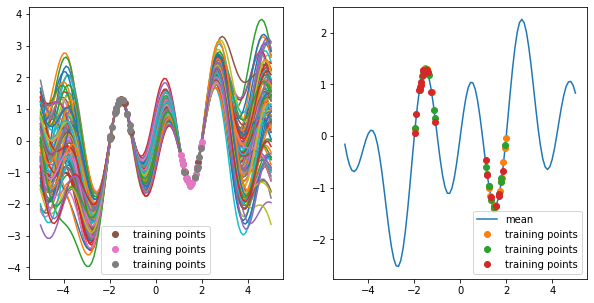

In [9]:
# print sampled lines
fig, ax = plt.subplots(1, model.n_hidden_layers+1, figsize=((model.n_hidden_layers+1)*5, 5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    for model_line in lines[5:]: # hidden outputs of each sampled model
        line = model_line[i]
        ax[i].plot(X_test[:,0], line.numpy()[:,0])
    # for model_line in lines[690:701]: # hidden outputs of each sampled model
    #     line = model_line[i]
    #     ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0], 'b')
for x, y in ds_train:
    ax[-2].plot(x[:,0], y[:,0], 'o', label='training points')
# for x, y in ds_test:
    # ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-2].legend()

# compute the mean of the sampled lines
line_output = []
for model_line in lines[5:]:
    line_output.append(model_line[-1]) #the final layer
line_mean = tf.reduce_mean(tf.concat(line_output, axis=-1), axis=-1)
ax[-1].plot(X_test[:,0], line_mean.numpy(), label='mean')
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
ax[-1].legend()
# fig.savefig('1layer-sin-2.png')

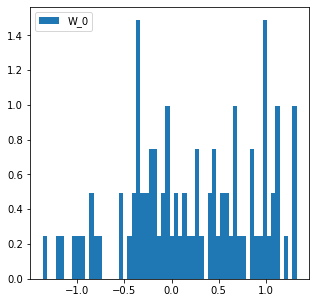

In [10]:
print_index = (25,0)
fig, ax = plt.subplots(1, model.n_hidden_layers, figsize=(model.n_hidden_layers*5,5))
for i in range(model.n_hidden_layers):
    W_print = []
    for W_model in W['W_'+str(i)][10:]:
        W_print.append(W_model[print_index])
    ax.hist(W_print, bins=60, density=True, label='W_'+str(i))
    ax.legend()
# fig.savefig('2w-sin-2.png')

# 1-layer DGPs (MCEM with Moving Windows)

In [11]:
# initialize the model
d_in = 1
d_out = 1
model = DemoRegressionDGP(d_in, d_out, n_hidden_layers=1, n_rf=100, n_gp=1,
                          likelihood=Gaussian(variance=0.01, trainable=True),
                          kernel_type_list=['RBF'], kernel_trainable=True,
                          random_fixed=True, input_cat=False)

In [12]:
model.Omega_hyperparams

[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [13]:
# EM sampler settings
lr_mcmc_0 = 0.01
sampler_EM = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                               lr_0=lr_mcmc_0, momentum_decay=0.9, resample_in_cycle_head=False,
                               start_sampling_epoch=0, epochs_per_cycle=50)

# Maximizer setttings
lr_maximizer = 0.01
optimizer = optimizers.Adam(learning_rate=lr_maximizer)
maximizer = MCEM_Q_maximizer_demo(model, num_training, optimizer)

# sampler settings after fixing hyper-params
lr_fixing_hyper_0 = 0.01
sampler_fixing_hyper = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                                         lr_0=lr_fixing_hyper_0, momentum_decay=0.9, resample_in_cycle_head=False,
                                         start_sampling_epoch=0, epochs_per_cycle=100)

In [14]:
# MCEM with Moving Windows settings and training
total_EM_steps = 50
_, _, lines, W = MCEM_windows(sampler_EM, maximizer, sampler_fixing_hyper, total_EM_steps, ds_train, window_size=10,
                             print_epoch_cycle_EM=50, print_epoch_cycle_fixing=100)

############### EM step 1 of total 50 steps. E Step:  ###############
#################### Sample No.1 at Epoch 49  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 49
Mean Log Likelihood -- train: -3.765904664993286, -- test: -88.61419677734375 
Root Mean Squared Error -- train: 0.3209221363067627, -- test: 1.3416247367858887 

#################### Sample No.2 at Epoch 99  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 99
Mean Log Likelihood -- train: -3.590348720550537, -- test: -116.5424575805664 
Root Mean Squared Error -- train: 0.31540435552597046, -- test: 1.5357481241226196 

#################### Sample No.3 at Epoch 149  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 149
Mean Log Likelihood -- train: -3.546091318130493, -- test: -103.41983032226562 
Root Mean Squared Error -- train: 0.3139980137348175, -- test: 1.447780966758728 

#################### Sample No.4 at Epoch 199  lr = 1.2021529605110715e-10 ####################


In [15]:
model.Omega_hyperparams

[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.15686728>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.3210245], dtype=float32)>]

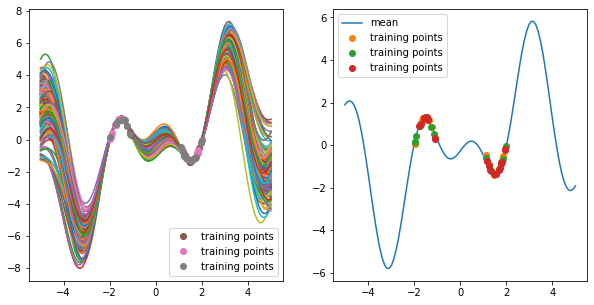

In [16]:
# print sampled lines
fig, ax = plt.subplots(1, model.n_hidden_layers+1, figsize=((model.n_hidden_layers+1)*5, 5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    for model_line in lines[5:]: # hidden outputs of each sampled model
        line = model_line[i]
        ax[i].plot(X_test[:,0], line.numpy()[:,0])
    # for model_line in lines[690:701]: # hidden outputs of each sampled model
    #     line = model_line[i]
    #     ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0], 'b')
for x, y in ds_train:
    ax[-2].plot(x[:,0], y[:,0], 'o', label='training points')
# for x, y in ds_test:
    # ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-2].legend()

# compute the mean of the sampled lines
line_output = []
for model_line in lines[5:]:
    line_output.append(model_line[-1]) #the final layer
line_mean = tf.reduce_mean(tf.concat(line_output, axis=-1), axis=-1)
ax[-1].plot(X_test[:,0], line_mean.numpy(), label='mean')
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
ax[-1].legend()
# fig.savefig('1layer-sin-2.png')

# 2-layer DGPs (MCEM)

In [36]:
# initialize the model
d_in = 1
d_out = 1
model = DemoRegressionDGP(d_in, d_out, n_hidden_layers=2, n_rf=100, n_gp=1,
                          likelihood=Gaussian(variance=0.01, trainable=True),
                          kernel_type_list=['RBF' for i in range(2)], kernel_trainable=True,
                          random_fixed=True, input_cat=False)

In [37]:
model.Omega_hyperparams

[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [38]:
# EM sampler settings
lr_mcmc_0 = 0.01
sampler_EM = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                               lr_0=lr_mcmc_0, momentum_decay=0.95, resample_in_cycle_head=False,
                               start_sampling_epoch=500, epochs_per_cycle=50)

# Maximizer setttings
lr_maximizer = 0.01
optimizer = optimizers.Adam(learning_rate=lr_maximizer)
maximizer = MCEM_Q_maximizer_demo(model, num_training, optimizer)

# sampler settings after fixing hyper-params
lr_fixing_hyper_0 = 0.01
sampler_fixing_hyper = MCEM_sampler_demo(model, ds_train, ds_test, num_training, batch_size, X_test,
                                         lr_0=lr_fixing_hyper_0, momentum_decay=0.95, resample_in_cycle_head=False,
                                         start_sampling_epoch=500, epochs_per_cycle=50)

In [39]:
# MCEM settings and training
total_EM_steps = 100
_, _, lines, W = MCEM(sampler_EM, maximizer, sampler_fixing_hyper, total_EM_steps, ds_train, 
                      num_samples_EM=20, num_samples_fixing_hyper=100,
                      print_epoch_cycle_EM=100, print_epoch_cycle_fixing=100)

############### EM step 1 of total 100 steps. E Step:  ###############
Sampling Epoch: 99
Mean Log Likelihood -- train: -815.6940307617188, -- test: -1271.96435546875 
Root Mean Squared Error -- train: 4.042468547821045, -- test: 5.04647970199585 

Sampling Epoch: 199
Mean Log Likelihood -- train: -1416.535888671875, -- test: -2025.98583984375 
Root Mean Squared Error -- train: 5.325259685516357, -- test: 6.367682933807373 

Sampling Epoch: 299
Mean Log Likelihood -- train: -643.2407836914062, -- test: -1207.2501220703125 
Root Mean Squared Error -- train: 3.590610980987549, -- test: 4.916571617126465 

Sampling Epoch: 399
Mean Log Likelihood -- train: -365.53643798828125, -- test: -415.1346435546875 
Root Mean Squared Error -- train: 2.7089483737945557, -- test: 2.886237144470215 

Sampling Epoch: 499
Mean Log Likelihood -- train: -62.375694274902344, -- test: -695.8560791015625 
Root Mean Squared Error -- train: 1.129241704940796, -- test: 3.7342731952667236 

#################### Sa

2022-08-24 16:17:06.072426: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


#################### Sample No.6 at Epoch 799  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 799
Mean Log Likelihood -- train: 1.2366821765899658, -- test: -51.91017532348633 
Root Mean Squared Error -- train: 0.05389830470085144, -- test: 1.0348827838897705 

#################### Sample No.7 at Epoch 849  lr = 1.2021529605110715e-10 ####################
#################### Sample No.8 at Epoch 899  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 899
Mean Log Likelihood -- train: 1.176368236541748, -- test: -54.38290023803711 
Root Mean Squared Error -- train: 0.06416493654251099, -- test: 1.0586198568344116 

#################### Sample No.9 at Epoch 949  lr = 1.2021529605110715e-10 ####################
#################### Sample No.10 at Epoch 999  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 999
Mean Log Likelihood -- train: 1.2487797737121582, -- test: -39.248104095458984 
Root Mean Squared Error -- train: 0.0515936650335788

2022-08-24 16:53:14.944443: W tensorflow/core/kernels/data/model_dataset_op.cc:205] Optimization loop failed: Cancelled: Operation was cancelled


#################### Sample No.19 at Epoch 1449  lr = 1.2021529605110715e-10 ####################
#################### Sample No.20 at Epoch 1499  lr = 1.2021529605110715e-10 ####################
Sampling Epoch: 1499
Mean Log Likelihood -- train: -3.362234592437744, -- test: -90.43609619140625 
Root Mean Squared Error -- train: 0.27874723076820374, -- test: 1.2126407623291016 

********************  End of Sampling  ********************
Number of sampled models: 20 
Test Log Likelihood of all sampled models: -3.617016315460205
Test Root MSE of all sampled models: 1.5152512788772583
********************************************************************** 

############### EM step 70 of total 100 steps, M Step:  ###############
**********************************************************************
Q function is -5.315213680267334 averaged by 20 samples.
********************************************************************** 

############### EM step 71 of total 100 steps. E Step:  #########

In [40]:
model.Omega_hyperparams

[<tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.19090846>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.04778704], dtype=float32)>,
 <tf.Variable 'log_amplitude:0' shape=() dtype=float32, numpy=0.04337507>,
 <tf.Variable 'log_inv_length_scale:0' shape=(1,) dtype=float32, numpy=array([0.19089498], dtype=float32)>]

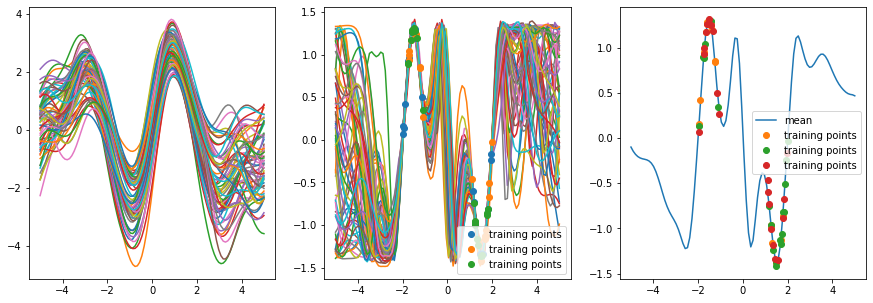

In [41]:
# print sampled lines
fig, ax = plt.subplots(1, model.n_hidden_layers+1, figsize=((model.n_hidden_layers+1)*5, 5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    for model_line in lines[:60]: # hidden outputs of each sampled model
        line = model_line[i]
        ax[i].plot(X_test[:,0], line.numpy()[:,0])
    # for model_line in lines[690:701]: # hidden outputs of each sampled model
    #     line = model_line[i]
    #     ax[i].plot(X_test.numpy()[:,0], line.numpy()[:,0], 'b')
for x, y in ds_train:
    ax[-2].plot(x[:,0], y[:,0], 'o', label='training points')
# for x, y in ds_test:
    # ax[-1].plot(x[:,0], y[:,0], '*', label='ground truth')
ax[-2].legend()

# compute the mean of the sampled lines
line_output = []
for model_line in lines[:64]:
    line_output.append(model_line[-1]) #the final layer
line_mean = tf.reduce_mean(tf.concat(line_output, axis=-1), axis=-1)
ax[-1].plot(X_test[:,0], line_mean.numpy(), label='mean')
for x, y in ds_train:
    ax[-1].plot(x[:,0], y[:,0], 'o', label='training points')
ax[-1].legend()
# fig.savefig('2layer-sin.png')

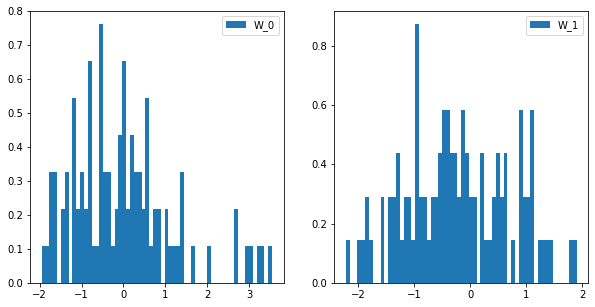

In [42]:
print_index = (25,0)
fig, ax = plt.subplots(1, model.n_hidden_layers, figsize=(model.n_hidden_layers*5,5))
ax = ax.flatten()
for i in range(model.n_hidden_layers):
    W_print = []
    for W_model in W['W_'+str(i)][:]:
        W_print.append(W_model[print_index])
    ax[i].hist(W_print, bins=60, density=True, label='W_'+str(i))
    ax[i].legend()
# fig.savefig('2w-sin-2.png')

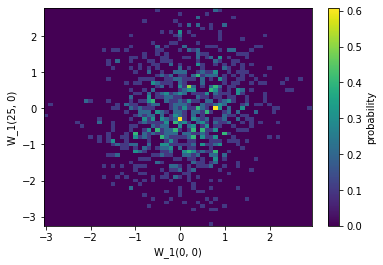

In [41]:
# try to show the correlation of two weights
print_index_1 = (0,0)
print_index_2 = (25,0)
W_print_1 = []
W_print_2 = []
for W_model in W['W_'+ str(1)][10:]:
    W_print_1.append(W_model[print_index_1])
    W_print_2.append(W_model[print_index_2])
plt.hist2d(W_print_1, W_print_2, bins=60, density=True)
plt.xlabel(f'W_1{print_index_1}')
plt.ylabel(f'W_1{print_index_2}')
cbar = plt.colorbar()
cbar.ax.set_ylabel('probability')
plt.savefig('correlation-sin-2.png')